In [18]:
import gym
from gym import spaces
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import sys
import random

# Exploration rate (epsilon) determines the probability of selecting a random action
epsilon = 0.5

# Store the original stdout
#original_stdout = sys.stdout

# Open /dev/null (on Unix/Linux) or nul (on Windows) to suppress output
#with open(os.devnull, 'w') as null_file:
#    sys.stdout = null_file

#state[0]  'Annual Volume':
#state[1]  'Availability': 
#state[2]  'Distance': 
#state[3]  'Necessity': 
#state[4]  'Modelling': 

A = 1  # Coefficient for volume
B = 0.001  # Coefficient for availability
C = 10  # Coefficient for distance
D = 1  # Coefficient for necessity
E = 20  # Coefficient for modelling


class CustomEnvironment(gym.Env):
    def __init__(self):
        super(CustomEnvironment, self).__init__()
        
        self.state_ranges = {
            'Annual Volume': (0.0, 1000.0), #hectometros3
            'Availability': (-1000.0, 1.0), # hectometros3
            'Distance': (0.0, 100.0),# kms 
            'Necessity': (0.0, 1000.0), #lts/dia
            'Modelling': (0.0, 100.0) #percentage
        }        
        # Define the possible actions
        self.actions = ['Repair leaking', 'Construction of aqueducts', 'Dam construction', 'Perform Studies']
        self.num_actions = len(self.actions)
        
        # Define the action and state spaces
        self.action_space = spaces.Discrete(self.num_actions)
            
        
        self.observation_space = spaces.Dict({
            'Annual Volume': spaces.Box(low=self.state_ranges['Annual Volume'][0], high=self.state_ranges['Annual Volume'][1], shape=(1,), dtype=np.float32),
            'Availability': spaces.Box(low=self.state_ranges['Availability'][0], high=self.state_ranges['Availability'][1], shape=(1,), dtype=np.float32),
            'Distance': spaces.Box(low=self.state_ranges['Distance'][0], high=self.state_ranges['Distance'][1], shape=(1,), dtype=np.float32),
            'Necessity': spaces.Box(low=self.state_ranges['Necessity'][0], high=self.state_ranges['Necessity'][1], shape=(1,), dtype=np.float32),
            'Modelling': spaces.Box(low=self.state_ranges['Modelling'][0], high=self.state_ranges['Modelling'][1], shape=(1,), dtype=np.float32)
        })
        
        # Initialize the current state
        self.current_state = None
    
        # Initialize state
        
        self.state = np.zeros(5)
        
        self.step_counter = 0
        self.max_steps = 10

    def initiate(self,states):
        self.state=np.array(states)
        return self.state
      
    def _custom_action_mapping(self, state, action):
#state[0]  'Annual Volume':
#state[1]  'Availability': 
#state[2]  'Distance': 
#state[3]  'Necessity': 
#state[4]  'Modelling': 
#estados=[14,-4.0,80,220,0]

        if action == 0:  # 'Repair leaking'
            self.state[1] += 2 
        elif action == 1:  # 'Construction of aqueducts'
            #state[1] -= 1
            self.state[2] -= 5
        elif action == 2:  # 'Dam construction'
            self.state[0] += 100 if (state[4] == 100) else 0
            self.state[1] += 100 if (state[4] == 100) else 0
            self.state[3] -= 10
        elif action == 3:  # 'Perform Studies'
            self.state[4] += 10 if (state[4] >= 50) else 0
            self.state[4] += 10 if (state[3] >= 0) else 0
            self.state[3] -= 1
        else:
            self.state[5] += 0.1

    def try_action(env, state, action):
        next_state, reward, done, _ = env.step(action)
        while not done and not env.is_action_possible(action):
            action = np.random.choice(2)  # Choose a random action as a fallback
            next_state, reward, done, _ = env.step(action)
        return next_state, reward, done
           
            
    def is_action_possible(self, action):
        act=True
        if action == 0:  # 'Repair leaking'
            act = False if self.state[1] >= 1 else act
        elif action == 1: # 'Construction of aqueducts'
            act = False if self.state[2] <= 5 else act
        elif action == 2: # 'Dam Construction'
            act = False if self.state[4] <= 90 else act
 #           act = False if self.state[4] >= 50 else act
        else:
            act=act
        return act
                       
            
    def step(self, action):
        while not self.is_action_possible(action):
            action = np.random.choice(self.num_actions)  # Choose a random action as a fallback

        self._custom_action_mapping(self.state, action)
        reward = self.calculate_reward()
        done = self.is_done()
        self.step_counter += 1
        return self.state, reward, done, {}
    
    
    def reset(self):
        # Reset the environment to the initial state
        self.state = np.zeros(5)
        self.step_counter = 0
        return self.state

    def render(self, mode='human'):

        # Implement any necessary rendering logic
        pass

    def close(self):
        # Clean up resources, if any
        pass

    def calculate_reward(self):
        volume = self.state[0]
        availability = self.state[1]
        distance = self.state[2]
        necessity = self.state[3]
        modelling = self.state[4]

#state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
      

#A = 1  # Coefficient for volume
#B = 1  # Coefficient for availability
#C = 1  # Coefficient for distance
#D = 1  # Coefficient for necessity
#E = 1  # Coefficient for modelling

    
    
        reward= A*volume+B*availability-(C*distance)-(D*necessity)+E*modelling
        return reward

    def is_done(self):        
        return ((self.state[4] >= 100))

# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(5,), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Create the custom environment
env = CustomEnvironment()

#state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
  
    #state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
    
    
    
estados=[14,-4.0,80,220,0]
env.initiate(estados)
print("Estados iniciales para empezar ", env.state)

# Training loop
num_episodes = 30
discount_factor = 0.9 
min_reward = -1500
max_reward = 150
total_rewards = []

q_value_history = {action: [] for action in env.actions}


for episode in range(num_episodes):
    state = env.reset()
    state = env.initiate(estados)
    state = np.reshape(state, [1, 5])  # Reshape the state for the neural network input
    total_reward = 0  # Initialize the total reward for this episode

    for step in range(200):
        # Select an action based on the current state and the model's predictions
        
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            # Choose a random action
            action = np.random.choice(4)
        else:
            # Choose the action with the highest Q-value
            action_probs = model.predict(state)[0]
            #action = np.argmax(action_probs)
            action = np.random.choice(4, p=action_probs)     
        
           # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # If the action is not possible from the current state, try another action
        while not done and not env.is_action_possible(action):
            action = np.random.choice(2)  # Choose a random action as a fallback
            next_state, reward, done, _ = env.step(action)
     
        
       # action_probs = model.predict(state)[0]
        
        # Take the selected action and observe the next state and reward
       # next_state, reward, done, _ = env.step(action)
        #min_reward = min(min_reward, reward)
        #max_reward = max(max_reward, reward)
        #print("min_reward,max_reward",min_reward,max_reward)
        normalized_reward = (reward - min_reward) / (max_reward - min_reward)
        #print("normalized_reward", normalized_reward)
        # Update the model with the observed transition
        print("['Annual Volume','Availability','Distance','Necessity', 'Modelling']")                   
        print(next_state, normalized_reward)
        next_state = np.reshape(next_state, [1, 5])  # Reshape the next state
        # Update the model with the observed transition
                # Q-learning update: Calculate the target Q-value using the Bellman equation
        target_vec = model.predict(state)
        #print(target_vec,next_state)
        next_action_value = np.max(model.predict(next_state)[0]) if not done else 0
        #print("target_vec,action",target_vec,action)
        target_vec[0][action] = normalized_reward + discount_factor * next_action_value
        #print("reward,discount_factor,next_action_value",reward,discount_factor,next_action_value)
        #print("target_vec,action",target_vec,action)
        # Update the model with the observed transition       
        model.fit(state, target_vec, epochs=1, verbose=0)

        q_values = model.predict(state)[0]
        for action_idx, action in enumerate(env.actions):
            q_value_history[action].append(q_values[action_idx])
               
        
        state = next_state
        total_reward += normalized_reward
        if done:
            break

    if done:
        print("Episode {} completed after {} steps".format(episode + 1, step + 1))
    else:
        done = True
        print("Episode {} did not complete within {} steps".format(episode + 1, env.max_steps))
    
    total_rewards.append(total_reward)
        
state = env.reset()
state = np.reshape(state, [1, 5])

for step in range(2):
    print(step)
    action = np.argmax(model.predict(state)[0])
    #env.render()
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 5])
    state = next_state
    print(state)
    if done or step == 199:  # Terminate if done or maximum steps reached
        print("Test completed after {} steps".format(step + 1))
        break

env.close()

Estados iniciales para empezar  [ 14.  -4.  80. 220.   0.]
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.  -4.  75. 220.   0.] 0.32969454545454546
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.  -2.  70. 220.   0.] 0.3599987878787879
1/1 [==============================] - 0s 17ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.   0.  65. 220.   0.] 0.3903030303030303
1/1 [==============================] - 0s 17ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.   2.  55. 219.  10.] 0.5727284848484848
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.   2.  45. 219.  10.] 0.6333345454545454
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[ 14.   2.  40. 218.  20.] 0.7854557

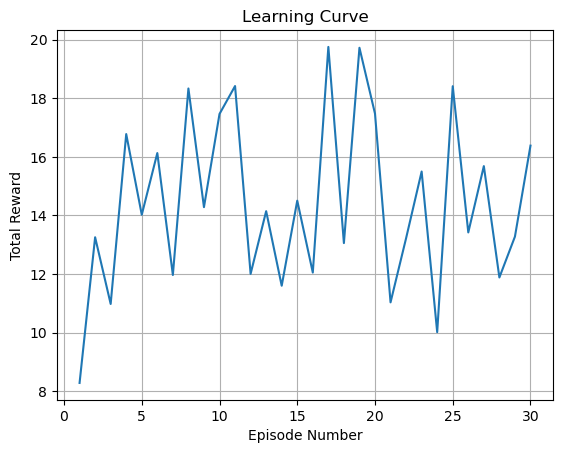

In [19]:
plt.plot(range(1, num_episodes + 1), total_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

In [28]:
len(q_value_history['Repair leaking'])

518

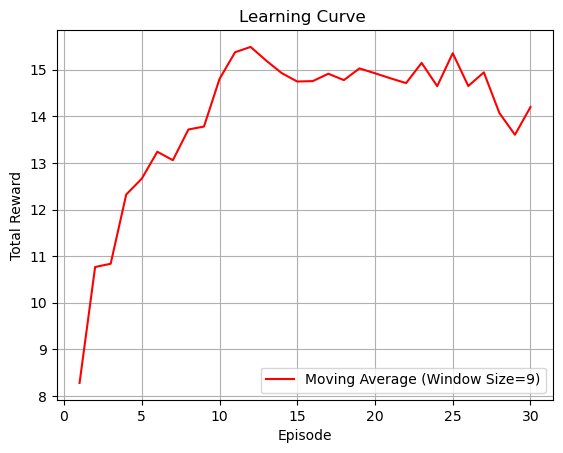

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Generate the episode numbers (assuming the rewards list has the same length as the number of episodes)
num_episodes = len(total_rewards)
episode_numbers = list(range(1, num_episodes + 1))

# Calculate the moving average using pandas
window_size = 9  # Adjust the window size as needed for the desired level of smoothing
moving_avg_rewards = pd.Series(total_rewards).rolling(window=window_size, min_periods=1).mean()

# Plot the learning curve with the moving average
#plt.plot(episode_numbers, total_rewards, label='Total Rewards', alpha=0.5)
plt.plot(episode_numbers, moving_avg_rewards, label=f'Moving Average (Window Size={window_size})', color='red')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve ')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig("learningcurve.png",format="PNG")


In [39]:
q_value_history['Repair leaking']

[5.649413e-16,
 1.342259e-14,
 8.7400204e-13,
 3.5777725e-11,
 6.691374e-10,
 2.3749398e-09,
 1.2524506e-08,
 2.1209448e-08,
 2.5572955e-09,
 1.4120966e-10,
 4.023082e-10,
 1.485231e-10,
 3.597562e-11,
 6.490055e-12,
 1.0681937e-12,
 2.1172525e-13,
 3.2976155e-14,
 1.6957584e-14,
 3.808816e-15,
 8.535005e-16,
 1.6889072e-16,
 2.686436e-17,
 3.5578345e-18,
 3.301736e-19,
 2.404843e-20,
 1.8585385e-20,
 1.5597589e-21,
 2.0997104e-13,
 6.599092e-23,
 1.9180732e-23,
 3.571081e-24,
 6.508087e-25,
 1.2116706e-25,
 6.001271e-26,
 1.5347415e-26,
 3.1560709e-27,
 2.3219445e-27,
 8.193875e-28,
 2.8507939e-27,
 8.402214e-28,
 1.6719035e-28,
 2.6954527e-29,
 3.18868e-30,
 2.5825952e-31,
 5.4720974e-21,
 9.119098e-34,
 1.4642088e-34,
 2.2163158e-35,
 2.4025495e-36,
 5.9485905e-36,
 3.2071147e-36,
 6.4890585e-37,
 3.4311374e-36,
 4.4540794e-37,
 5.5310433e-38,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.

In [21]:
# Evaluation loop

actions=['Repair leaking', 'Construction of aqueducts', 'Dam construction', 'Perform Studies']

num_episodes = 10  # You can adjust this number for more episodes
for episode in range(num_episodes):
    state = env.reset()
    state = env.initiate(estados)
    state = np.reshape(state, [1, 5])

    for step in range(200):
        action = np.argmax(model.predict(state)[0])
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 5])
        state = next_state

        if done or step == 199:  # Terminate if done or maximum steps reached
            print("Test episode {} completed after {} steps".format(episode + 1, step + 1))
            break


1/1 [==============================] - 0s 15ms/step
Test episode 1 completed after 8 steps
1/1 [==============================] - 0s 16ms/step
Test episode 2 completed after 8 steps
1/1 [==============================] - 0s 17ms/step
Test episode 3 completed after 8 steps
1/1 [==============================] - 0s 17ms/step
Test episode 4 completed after 8 steps
1/1 [==============================] - 0s 16ms/step
Test episode 5 completed after 8 steps
1/1 [==============================] - 0s 16ms/step
Test episode 6 completed after 8 steps
1/1 [==============================] - 0s 15ms/step
Test episode 7 completed after 8 steps
1/1 [==============================] - 0s 16ms/step
Test episode 8 completed after 8 steps
1/1 [==============================] - 0s 15ms/step
Test episode 9 completed after 8 steps
1/1 [==============================] - 0s 16ms/step
Test episode 10 completed after 8 steps


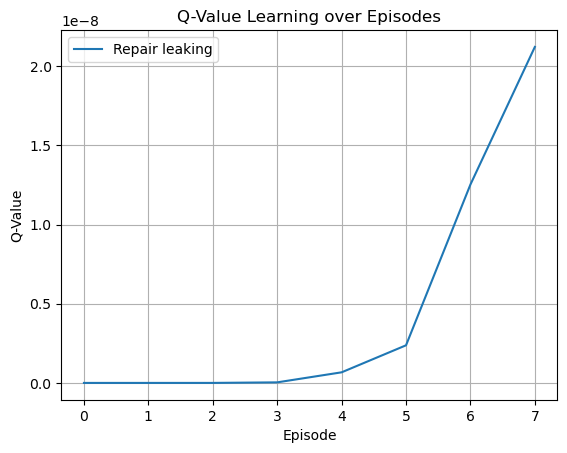

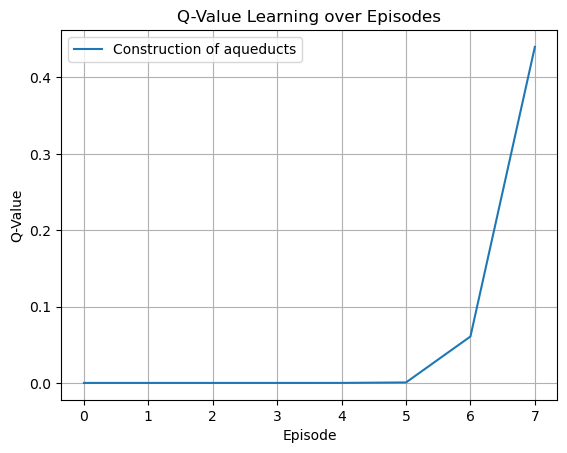

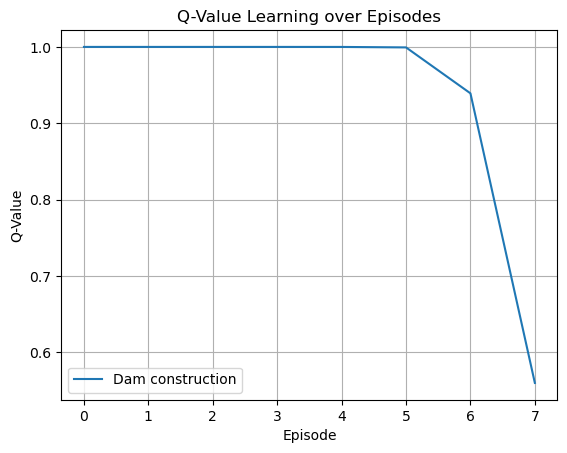

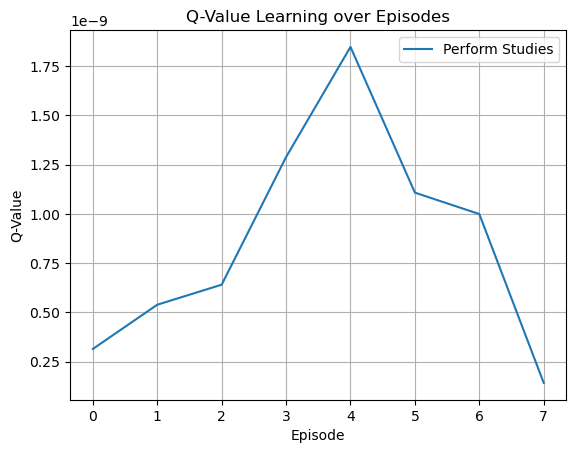

In [56]:
actions_to_plot=['Repair leaking', 'Construction of aqueducts', 'Dam construction', 'Perform Studies']
for act in actions_to_plot:
    plt.plot(range(8), q_value_history[act][0:8], label=act)
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.title('Q-Value Learning over Episodes')
    plt.legend()
    plt.grid(True)
    plt.savefig("Epis_"+act+".pdf")
    plt.show()

In [12]:
import gym
from gym import spaces
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import sys
import random

# Exploration rate (epsilon) determines the probability of selecting a random action
epsilon = 0.5


#state[0]  'Annual Volume':
#state[1]  'Availability': 
#state[2]  'Distance': 
#state[3]  'Necessity': 
#state[4]  'Modelling': 

A = 1  # Coefficient for volume
B = 0.001  # Coefficient for availability
C = 10  # Coefficient for distance
D = 1  # Coefficient for necessity
E = 20  # Coefficient for modelling


class CustomEnvironment(gym.Env):
    def __init__(self):
        super(CustomEnvironment, self).__init__()
        
        self.state_ranges = {
            'Annual Volume': (0.0, 1000.0), #hectometros3
            'Availability': (-1000.0, 1.0), # hectometros3
            'Distance': (0.0, 100.0),# kms 
            'Necessity': (0.0, 1000.0), #lts/dia
            'Modelling': (0.0, 100.0) #percentage
        }        
        # Define the possible actions
        self.actions = ['Repair leaking', 'Construction of aqueducts', 'Dam construction', 'Perform Studies']
        self.num_actions = len(self.actions)
        
        # Define the action and state spaces
        self.action_space = spaces.Discrete(self.num_actions)
                  
        self.observation_space = spaces.Dict({
            'Annual Volume': spaces.Box(low=self.state_ranges['Annual Volume'][0], high=self.state_ranges['Annual Volume'][1], shape=(1,), dtype=np.float32),
            'Availability': spaces.Box(low=self.state_ranges['Availability'][0], high=self.state_ranges['Availability'][1], shape=(1,), dtype=np.float32),
            'Distance': spaces.Box(low=self.state_ranges['Distance'][0], high=self.state_ranges['Distance'][1], shape=(1,), dtype=np.float32),
            'Necessity': spaces.Box(low=self.state_ranges['Necessity'][0], high=self.state_ranges['Necessity'][1], shape=(1,), dtype=np.float32),
            'Modelling': spaces.Box(low=self.state_ranges['Modelling'][0], high=self.state_ranges['Modelling'][1], shape=(1,), dtype=np.float32)
        })
        
        # Initialize the current state
        self.current_state = None
    
        # Initialize state
        
        self.state = np.zeros(5)
        
        self.step_counter = 0
        self.max_steps = 10

    def initiate(self,states):
        self.state=np.array(states)
        return self.state
      
    def _custom_action_mapping(self, state, action):
#state[0]  'Annual Volume':
#state[1]  'Availability': 
#state[2]  'Distance': 
#state[3]  'Necessity': 
#state[4]  'Modelling': 
#estados=[14,-4.0,80,220,0]

        if action == 0:  # 'Repair leaking'
            self.state[1] += 5 
        elif action == 1:  # 'Construction of aqueducts'
            #state[1] -= 1
            self.state[2] -= 5
        elif action == 2:  # 'Dam construction'
            self.state[0] += 100 if (state[4] == 100) else 0
            self.state[1] += 100 if (state[4] == 100) else 0
            self.state[3] -= 10
        elif action == 3:  # 'Perform Studies'
            self.state[4] += 10 if (state[4] >= 50) else 0
            self.state[4] += 10 if (state[3] >= 0) else 0
            self.state[3] -= 1
        else:
            self.state[5] += 0.1

            
    def is_action_possible(self, action):
        act=True
        if action == 0:  # 'Repair leaking'
            act = False if self.state[1] >= 15 else act
#        elif action == 1: # 'Construction of aqueducts'
#            act = False if self.state[2] <= 10 else act
 #           act = False if self.state[4] >= 50 else act
        else:
            act=act
        return act
                       
            
    def step(self, action):   

#estados=[14,-4.0,80,220,0]
#estados=[14,-4.0,80,220,0]
# Define the action-state mapping
#        action_mapping = {              
#state[0]  'Annual Volume':
#state[1]  'Availability': 
#state[2]  'Distance': 
#state[3]  'Necessity': 
#state[4]  'Modelling':                 
#reward= A*volume+B*availability-(C*distance)-(D*necessity)+E*modelling 
        self._custom_action_mapping(self.state, action)
        reward = self.calculate_reward()
        done = self.is_done()
        self.step_counter += 1
        return state, reward, done, {}
    
    def reset(self):
        # Reset the environment to the initial state
        self.state = np.zeros(5)
        self.step_counter = 0
        return self.state

    def render(self, mode='human'):

        # Implement any necessary rendering logic
        pass

    def close(self):
        # Clean up resources, if any
        pass

    def calculate_reward(self):
        volume = self.state[0]
        availability = self.state[1]
        distance = self.state[2]
        necessity = self.state[3]
        modelling = self.state[4]

#state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
      

#A = 1  # Coefficient for volume
#B = 1  # Coefficient for availability
#C = 1  # Coefficient for distance
#D = 1  # Coefficient for necessity
#E = 1  # Coefficient for modelling

    
    
        reward= A*volume+B*availability-(C*distance)-(D*necessity)+E*modelling
        return reward

    def is_done(self):        
        return ((self.state[4] >= 100) and (self.state[1] > 1))

# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(5,), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Create the custom environment
env = CustomEnvironment()

#state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
  
    #state[0]  'Annual Volume': (0.0, 1000.0), #hectometros3
#state[1]  'Availability': (-1000.0, 1000.0), # hectometros3
#state[2]  'Distance': (0.0, 100.0),# kms 
#state[3]  'Necessity': (0.0, 1000.0), #lts/dia
#state[4]  'Modelling': (0.0, 100.0) #percentage
    
    
    
estados=[14,-4.0,80,220,0]
env.initiate(estados)
print("Estados iniciales para empezar ", env.state)

# Training loop
num_episodes = 1
discount_factor = 0.9 
min_reward = -1500
max_reward = 150


for episode in range(num_episodes):
    state = env.reset()
    state = env.initiate(estados)
    state = np.reshape(state, [1, 5])  # Reshape the state for the neural network input

    for step in range(200):
        # Select an action based on the current state and the model's predictions
        
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            # Choose a random action
            action = np.random.choice(4)
        else:
            # Choose the action with the highest Q-value
            action_probs = model.predict(state)[0]
            #action = np.argmax(action_probs)
            action = np.random.choice(4, p=action_probs)
        
        
           # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # If the action is not possible from the current state, try another action
        while not done and not env.is_action_possible(action):
            action = np.random.choice(2)  # Choose a random action as a fallback
            next_state, reward, done, _ = env.step(action)
        
        normalized_reward = (reward - min_reward) / (max_reward - min_reward)
        #print("normalized_reward", normalized_reward)
        # Update the model with the observed transition
        print("['Annual Volume','Availability','Distance','Necessity', 'Modelling']")                   
        print(next_state, normalized_reward)
        next_state = np.reshape(next_state, [1, 5])  # Reshape the next state
        # Update the model with the observed transition
                # Q-learning update: Calculate the target Q-value using the Bellman equation
        target_vec = model.predict(state)
        #print(target_vec,next_state)
        next_action_value = np.max(model.predict(next_state)[0]) if not done else 0
        #print("target_vec,action",target_vec,action)
        target_vec[0][action] = normalized_reward + discount_factor * next_action_value
        #print("reward,discount_factor,next_action_value",reward,discount_factor,next_action_value)
        #print("target_vec,action",target_vec,action)
        # Update the model with the observed transition       
        model.fit(state, target_vec, epochs=1, verbose=0)

        state = next_state

        if done:
            break

    if done:
        print("Episode {} completed after {} steps".format(episode + 1, step + 1))
    else:
        done = True
        print("Episode {} did not complete within {} steps".format(episode + 1, env.max_steps))

# Test the trained model
#sys.stdout = original_stdout
state = env.reset()
state = np.reshape(state, [1, 5])

for step in range(2):
    print(step)
    action = np.argmax(model.predict(state)[0])
    #env.render()
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 5])
    state = next_state
    print(state)
    if done or step == 199:  # Terminate if done or maximum steps reached
        print("Test completed after {} steps".format(step + 1))
        break

env.close()

Estados iniciales para empezar  [ 14.  -4.  80. 220.   0.]
1/1 [==============================] - 0s 51ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[[ 14.  -4.  80. 219.  10.]] 0.42120969696969696
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[[ 14.  -4.  80. 218.  20.]] 0.5430278787878787
1/1 [==============================] - 0s 15ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[[ 14.  -4.  80. 208.  20.]] 0.5490884848484848
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[[ 14.  -4.  75. 208.  20.]] 0.5793915151515151
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance','Necessity', 'Modelling']
[[ 14.  -4.  75. 198.  20.]] 0.5854521212121212
1/1 [==============================] - 0s 16ms/step
['Annual Volume','Availability','Distance',

In [6]:
import pygame
import sys

pygame.init()

# Set up the window
window_width, window_height = 400, 300
window = pygame.display.set_mode((window_width, window_height))
pygame.display.set_caption('CUadro Rojo')

# Set up the red square
square_width, square_height = 50, 50
square_x, square_y = 0, window_height // 2 - square_height // 2
square_speed = 2

clock = pygame.time.Clock()

while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

    # Move the square horizontally
    square_x += square_speed

    # If the square goes off the screen, reset its position
    if square_x > window_width:
        square_x = -square_width

    # Draw the red square and update the window
    window.fill((255, 255, 255))
    pygame.draw.rect(window, (255, 0, 0), (square_x, square_y, square_width, square_height))
    pygame.display.update()

    # Set the frames per second
    clock.tick(30)


SystemExit: 

In [6]:
import pygame
import sys

pygame.init()

# Set up the window
window_width, window_height = 400, 300
window = pygame.display.set_mode((window_width, window_height))
pygame.display.set_caption('CUadro Rojo')

# Set up the red square
square_width, square_height = 50, 50
square_x, square_y = 0, window_height // 2 - square_height // 2
square_speed = 2

clock = pygame.time.Clock()

while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

    # Move the square horizontally
    square_x += square_speed

    # If the square goes off the screen, reset its position
    if square_x > window_width:
        square_x = -square_width

    # Draw the red square and update the window
    window.fill((255, 255, 255))
    pygame.draw.rect(window, (255, 0, 0), (square_x, square_y, square_width, square_height))
    pygame.display.update()

    # Set the frames per second
    clock.tick(30)


SystemExit: 

##### !pip install tensorflow

In [2]:
import gym
from gym import spaces
import numpy as np
from tensorflow import keras

class CustomEnvironment(gym.Env):
    def __init__(self):
        super(CustomEnvironment, self).__init__()

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)

        # Initialize state
        self.state = np.zeros(6)
        self.step_counter = 0
        self.max_steps = 10

    def step(self, action):
        # Take action and calculate the next state and reward
        if action == 0:
            self.state[0] += 0.1
        elif action == 1:
            self.state[1] += 0.1
        elif action == 2:
            self.state[2] += 0.1
        elif action == 3:
            self.state[3] += 0.1
        elif action == 4:
            self.state[4] += 0.1
        else:
            self.state[5] += 0.1

        reward = self.calculate_reward()
        done = self.is_done()

        self.step_counter += 1

        return self.state, reward, done, {}

    def reset(self):
        # Reset the environment to the initial state
        self.state = np.zeros(6)
        self.step_counter = 0
        return self.state

    def render(self, mode='human'):
        # Implement any necessary rendering logic
        pass

    def close(self):
        # Clean up resources, if any
        pass

    def calculate_reward(self):
        # Implement your own reward calculation logic based on the current state
        return 1.0

    def is_done(self):
        # Define the termination condition for the environment
        return self.step_counter >= self.max_steps

# Define the neural network model
model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(6,), activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Create the custom environment
env = CustomEnvironment()

# Training loop
num_episodes = 10
for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, 6])  # Reshape the state for the neural network input

    for step in range(200):
        # Select an action based on the current state and the model's predictions
        action_probs = model.predict(state)[0]
        action = np.random.choice(2, p=action_probs)

        # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        print(next_state, reward)
        next_state = np.reshape(next_state, [1, 6])  # Reshape the next state

        # Update the model with the observed transition
        target = reward if done else reward + np.amax(model.predict(next_state)[0])
        target_vec = model.predict(state)
        target_vec[0][action] = target
        model.fit(state, target_vec, epochs=1, verbose=0)

        state = next_state

        if done:
            break

    if done:
        print("Episode {} completed after {} steps".format(episode + 1, step + 1))
    else:
        done = True
        print("Episode {} did not complete within {} steps".format(episode + 1, env.max_steps))

# Test the trained model
state = env.reset()
state = np.reshape(state, [1, 6])

for step in range(200):
    print(step)
    action = np.argmax(model.predict(state)[0])
    env.render()
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 6])
    state = next_state
    print(state)
    if done or step == 199:  # Terminate if done or maximum steps reached
        print("Test completed after {} steps".format(step + 1))
        break

env.close()


1/1 [==============================] - 0s 41ms/step
[0.  0.1 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 17ms/step
[0.  0.2 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 16ms/step
[0.  0.3 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 15ms/step
[0.1 0.3 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 16ms/step
[0.1 0.4 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 16ms/step
[0.1 0.5 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 16ms/step
[0.1 0.6 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 18ms/step
[0.2 0.6 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 16ms/step
[0.3 0.6 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 17ms/step
[0.3 0.7 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 15ms/step
[0.4 0.7 0.  0.  0.  0. ] 1.0
1/1 [==============================] - 0s 17ms/step
Episode 1 completed after 11 steps
1/1 [======

In [7]:
import pygame
import sys
import random

pygame.init()

# Set up the window
window_width, window_height = 800, 600
window = pygame.display.set_mode((window_width, window_height))
pygame.display.set_caption('Simple Cityscape')

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (150, 150, 150)
BLUE = (0, 0, 255)

# Function to draw a building
def draw_building(x, y, width, height, color):
    pygame.draw.rect(window, color, (x, y - height, width, height))

def draw_cityscape():
    num_buildings = 10
    min_building_width = 30
    max_building_width = 100
    min_building_height = 100
    max_building_height = 400

    x_offset = 0

    for _ in range(num_buildings):
        building_width = random.randint(min_building_width, max_building_width)
        building_height = random.randint(min_building_height, max_building_height)
        building_color = GRAY if random.random() < 0.8 else BLUE

        draw_building(x_offset, window_height, building_width, building_height, building_color)

        x_offset += building_width + random.randint(20, 50)

# Main game loop
clock = pygame.time.Clock()

while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

    window.fill(WHITE)
    draw_cityscape()
    pygame.display.update()

    # Set the frames per second
    clock.tick(30)


SystemExit: 

In [3]:
plt.switch_backend('QtAgg')

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Force the usage of the Qt5Agg backend
matplotlib.use('QtAgg')  # or 'QtAgg' if 'Qt5Agg' doesn't work on your system

# Generate random data for the histogram (replace this with your own data)
data = np.random.normal(loc=50, scale=10, size=1000)

# Create the histogram using Matplotlib
plt.hist(data, bins=20, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Display the histogram in a separate window
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, input_shape=(5,), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


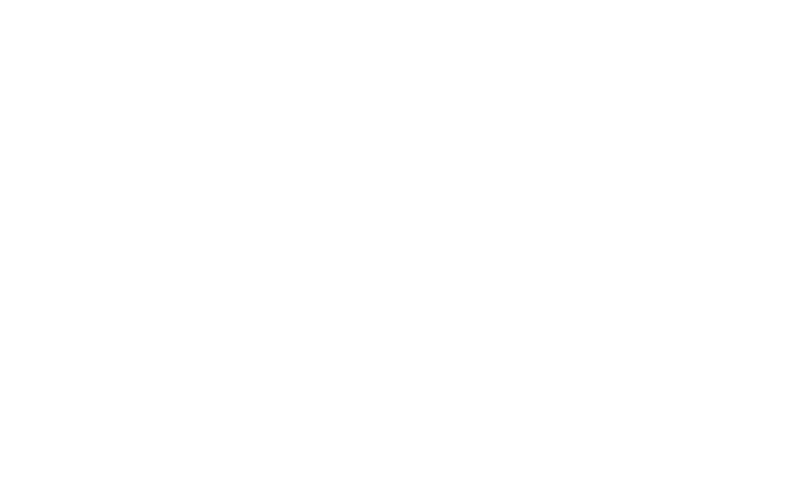

Model architecture plotted and saved to 'model_architecture.png'.


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

def create_custom_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, input_shape=(5,), activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

def plot_model_architecture(model):
    plt.figure(figsize=(10, 6))
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')
    plt.axis('off')
    plt.show()
    print("Model architecture plotted and saved to 'model_architecture.png'.")

# Create the model
model = create_custom_model()

# Plot and save the model architecture
plot_model_architecture(model)
